# CropArray example

---

## Notebook summary 


- Load a microscope image o video
- Tracking spots on the image and generate a pandas dataframe with the spots locations
- Creating a croparray with the image and dataframe

----

## Importing libraries


----

In [1]:
# To manipulate arrays
import numpy as np 
import pandas as pd
import xarray as xr
from skimage.io import imread
import trackpy as tp
import matplotlib as mpl 
import matplotlib.pyplot as plt 
from matplotlib import gridspec
from scipy.ndimage import gaussian_filter1d
from scipy.ndimage import gaussian_laplace
from skimage import img_as_float64, img_as_uint
import seaborn as sns; sns.set()  
import os
import pathlib # for working with windows paths
import sys
current_dir = pathlib.Path().absolute()
croparray_dir = current_dir.parents[0].joinpath('croparray')
sys.path.append(str(croparray_dir))
import crop_array_tools as ca
# %matplotlib inline 
plt.style.use('dark_background')

## Parameters for quantification


----

In [2]:
# parameters
particle_diameter= 7 #(3, 7, 7)   # Spot diameter :  z,y,x size of the spot      
tracking_channel = 0          # Channel  used for tracking
min_trajectory_length = 10    # Minimal number of frames to be consider as a trajectory
max_distance_movement = particle_diameter*2
# selecting time and z for visualization
selected_time = 4 
selected_z = 3 
# Visualization. Static image taking a given time point. Plotting the maximum projection in Z for a given channel.
selected_channel = 0
drop_size = 3

## Loading data


----

In [3]:
# Video directory
img_file_path = current_dir.parents[0].joinpath('dataBase','Hela_confocal.tif')  
# Read in video; note I added an fov dimension using np.array since this is only 1 fov
img = imread(str(img_file_path))  # (33, 7, 472, 312, 3)
img_croparray = np.expand_dims(img,axis=0) 
img_croparray.shape # dimensions MUST be (fov, f , z, y, x, ch)

(1, 33, 7, 472, 312, 3)

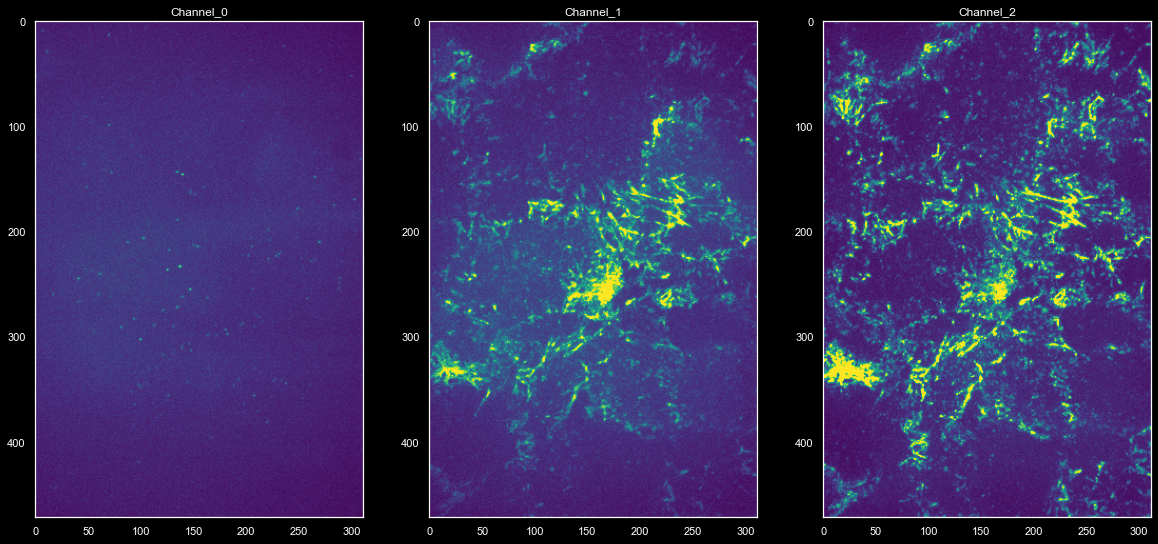

In [4]:
# plotting original image
# Just examining one of the images
num_channels = 3
fig, ax = plt.subplots(nrows=1, ncols=num_channels,figsize=(20,10))
for i in range(0,num_channels):
    ax[i].imshow(np.max(img_croparray[0,selected_time,:,:,:,i] ,axis=0),cmap='viridis' )
    ax[i].grid(False)
    ax[i].set_title('Channel_'+str(i))

## Spot detection and tracking


----

In [5]:
# Detecting particles for each frame
def optimization_tracking(img,particle_diameter=5,max_distance_movement=5,min_trajectory_length=5, num_iterations = 100,show_plots=True):
    num_spots = []
    number_time_points = img.shape[0]
    if number_time_points >20:
        smothing_window = 5
    else:
        smothing_window = 2
    tested_intensities = np.round(np.linspace(40, np.amax(img), num_iterations ),0)
    for i, int_tested in enumerate (tested_intensities):
        try:
            f = tp.locate(img[0,:,:], diameter=particle_diameter, minmass = int_tested )
            num_spots.append(len(f))
        except:
            num_spots.append(0)
    num_spots =np.array(num_spots)   
    
    # Optimization process for selecting intensity
    vector_detected_spots = num_spots/ np.max(num_spots)
    smooth_vector_detected_spots = gaussian_filter1d(vector_detected_spots, smothing_window)
    second_derivative_vector_detected_spots = np.gradient(np.gradient(smooth_vector_detected_spots))      # Second deriivative
    inflection_points = np.where(np.diff(np.sign(second_derivative_vector_detected_spots)))[0]  # Finding the inflection points
    
    selected_minmass = np.round(tested_intensities [inflection_points[0]],0)
    # Tracking after finding the best threshold
    f = tp.batch(img, diameter=particle_diameter,minmass=selected_minmass)
    linked = tp.link_df(f, max_distance_movement) # Linking trajectories
    tracking_df = tp.filter_stubs(linked, min_trajectory_length) # Filtering with minimum length
    
    # Renaming columns names
    tracking_df['z']= 0  
    tracking_df.rename(columns={'x': 'xc','y': 'yc', 'z': 'zc', 'frame': 'f','particle':'id','mass':'MEAN_INTENSITY'}, inplace=True, errors='raise')
    # Chaning data type
    spots = tracking_df.astype({'zc': int,'yc': int,'xc': int,'f': int,'id': int,'MEAN_INTENSITY': int})
    spots['fov']= 0  
    # Selecting some columns
    spots=spots[['fov','id','f','zc','yc','xc','MEAN_INTENSITY']]
    # From trackpy ids are not in order nor consecutive. This code replaces these values and make them ordered consecutive numbers.
    unique_spots_id = spots.id.unique() # unique spots ids
    # Replacing spots with id number.
    for i,id_spot in enumerate(unique_spots_id):
        spots.loc[spots.id == id_spot,'id']=- i # To avoid replacing and mixing different numbers. I am making the new id a negative number.
    spots['id'] = spots['id'].abs() # now getting the absolute value.
    print('Detected trajectories: ',np.max(spots.id)+1 )
    
    if show_plots==True:
        plt.figure(figsize =(5,5))
        plt.plot(smooth_vector_detected_spots/np.max(smooth_vector_detected_spots) , label='norm detected_spots',linewidth=5,color='lime')
        plt.plot(second_derivative_vector_detected_spots / np.max(second_derivative_vector_detected_spots), label=r"$f''(spots)$",color='orangered',linewidth=5)
        for i, infl in enumerate(inflection_points, 1):
            plt.plot(infl,0, 'o',label='Inflection Point '+str(i), markersize=20, markerfacecolor='cyan')
        plt.legend(bbox_to_anchor=(1.55, 1.0))
        plt.ylim(-0.2,1.1)
        plt.xlabel('Threshold index', size=16)
        plt.ylabel('Norm. number of spots', size=16)
        plt.show()
    return spots 


In [6]:
img_2D = np.amax(img_croparray[0,:,:,:,:,tracking_channel],axis=1)   #(fov, f , z, y, x, ch)
img_2D.shape # ( f, y, x)


(33, 472, 312)

Frame 32: 156 trajectories present.
Detected trajectories:  108


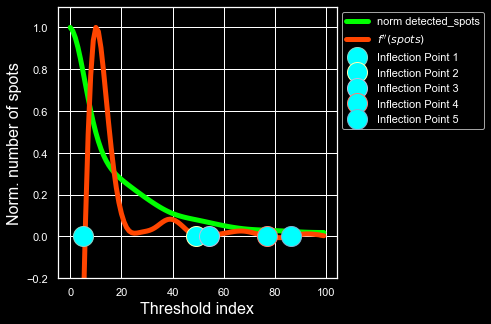

In [7]:
spots_df = optimization_tracking(img_2D,particle_diameter=particle_diameter,max_distance_movement=max_distance_movement,
                                    min_trajectory_length=min_trajectory_length, num_iterations = 100,show_plots=True)

In [8]:
def plotting_spots(img_2D,dataframe):
    n_particles = dataframe['id'].nunique()
    NUM_ROWS = 1
    NUM_COLUMNS = 3
    index_video = 0
    title_str = 'Video'
    individual_figure_size = 7
    gs = gridspec.GridSpec(NUM_ROWS, NUM_COLUMNS)
    gs.update(wspace = 0.01, hspace = 0.1) # set the spacing between axes.
    # Figure with raw video
    fig = plt.figure(figsize = (individual_figure_size*NUM_COLUMNS, individual_figure_size*NUM_ROWS))
    ax = fig.add_subplot(gs[index_video])
    #img_projection=np.max(img[0,selected_time,:,:,:,selected_channel] ,axis=0)
    ax.imshow(img_2D,cmap='gray') 
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set(title = title_str + ' Original')
    # Figure with filtered video
    ax = fig.add_subplot(gs[index_video+1])
    ax.imshow(img_2D,cmap='gray_r') 
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set(title = title_str + ' Reverse color' )
    # Figure with filtered video and marking the spots
    ax = fig.add_subplot(gs[index_video+2])
    ax.imshow(img_2D,cmap='gray_r') 
    # Plots the detected spots.
    for k in range (0, n_particles):
        frames_part = dataframe.loc[dataframe['id'] == dataframe['id'].unique()[k]].f.values
        if selected_time in frames_part: # plotting the circles for each detected particle at a given time point
            index_val = np.where(frames_part == selected_time)
            x_pos = int(dataframe.loc[dataframe['id'] == dataframe['id'].unique()[k]].xc.values[index_val])
            y_pos = int(dataframe.loc[dataframe['id'] == dataframe['id'].unique()[k]].yc.values[index_val])
            circle = plt.Circle((x_pos, y_pos), drop_size//2, color = 'red', fill = False)
            ax.add_artist(circle)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set(title = title_str + ' + Detected Spots' ) 
    plt.show()

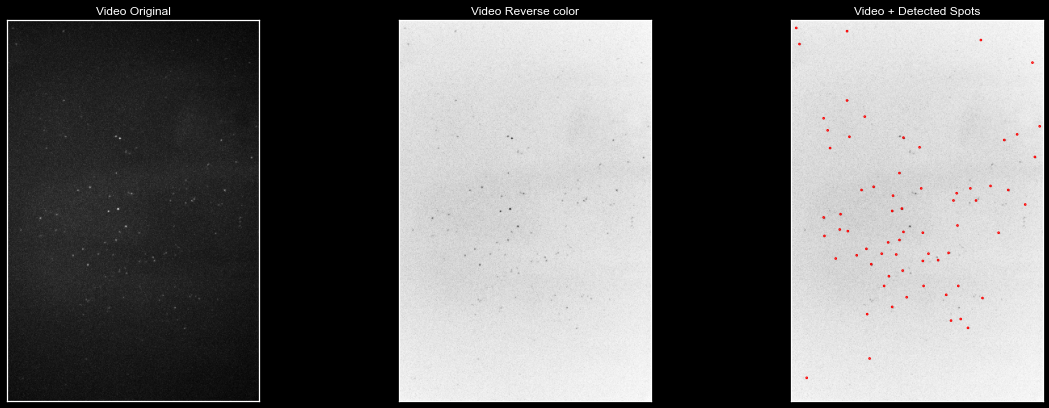

In [9]:
img_to_plot = np.max(img_croparray[0,selected_time,:,:,:,selected_channel] ,axis=0)
plotting_spots(img_2D=img_to_plot,dataframe=spots_df)

## Creating a CropArray


----

In [10]:
my_ca = ca.create_crop_array(img_croparray,spots_df,xy_pad=3)
my_ca

Original video dimensions:  (1, 33, 7, 472, 312, 3)
Padded video dimensions:  (1, 33, 7, 480, 320, 3)
Max # of spots per frame:  88
Shape of numpy array to hold all crop intensity data:  (1, 88, 33, 7, 7, 7, 3)
Shape of xc and yc numpy arrays:  (1, 88, 33, 3)
Shape of extra my_layers numpy array:  (3, 1, 88, 33)


<xarray.Dataset>
Dimensions:         (fov: 1, n: 88, t: 33, z: 7, y: 7, x: 7, ch: 3)
Coordinates:
  * fov             (fov) int64 0
  * n               (n) int16 0 1 2 3 4 5 6 7 8 9 ... 79 80 81 82 83 84 85 86 87
  * t               (t) int64 0 1 2 3 4 5 6 7 8 9 ... 24 25 26 27 28 29 30 31 32
  * z               (z) int64 0 1 2 3 4 5 6
  * y               (y) int64 -3 -2 -1 0 1 2 3
  * x               (x) int64 -3 -2 -1 0 1 2 3
  * ch              (ch) int64 0 1 2
Data variables:
    int             (fov, n, t, z, y, x, ch) int64 16 25 21 22 17 ... 0 0 0 0 0
    xc              (fov, n, t, ch) int64 10 10 10 46 46 46 138 ... 0 0 0 0 0 0
    yc              (fov, n, t, ch) int64 13 13 13 270 270 270 ... 0 0 0 0 0 0
    dx              int64 1
    dy              int64 1
    dz              int64 1
    dt              int64 1
    xy_pad          int64 3
    id              (fov, n, t) float64 0.0 1.0 4.0 5.0 2.0 ... 0.0 0.0 0.0 0.0
    zc              (fov, n, t) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    MEAN_INTENSITY  (fov, n, t) float64 114.0 137.0 191.0 103.0 ... 0.0 0.0 0.0
Attributes:
    name:     video_filename
    date:     video_date

In [11]:
# Create best-z projection using channel 1 (translation) as a reference. taking bestz +/- 1 here (roll_n = 3)
best_z = ca.best_z_proj(my_ca, ref_ch=1, disk_r=3, roll_n=3)
best_z = my_ca.int.sel(fov=0).max('z')
best_z.coords

Coordinates:
    fov      int64 0
  * n        (n) int16 0 1 2 3 4 5 6 7 8 9 10 ... 78 79 80 81 82 83 84 85 86 87
  * t        (t) int64 0 1 2 3 4 5 6 7 8 9 10 ... 23 24 25 26 27 28 29 30 31 32
  * y        (y) int64 -3 -2 -1 0 1 2 3
  * x        (x) int64 -3 -2 -1 0 1 2 3
  * ch       (ch) int64 0 1 2

In [12]:
# view the action of montage
my_ca_montage= ca.montage(best_z, row = 't', col = 'n')
my_ca_montage.dims

('r', 'c', 'ch')

## Plotting with Napari


----

In [13]:
# Napari 
%gui qt5 
import napari
from napari.utils import nbscreenshot
viewer = napari.Viewer()

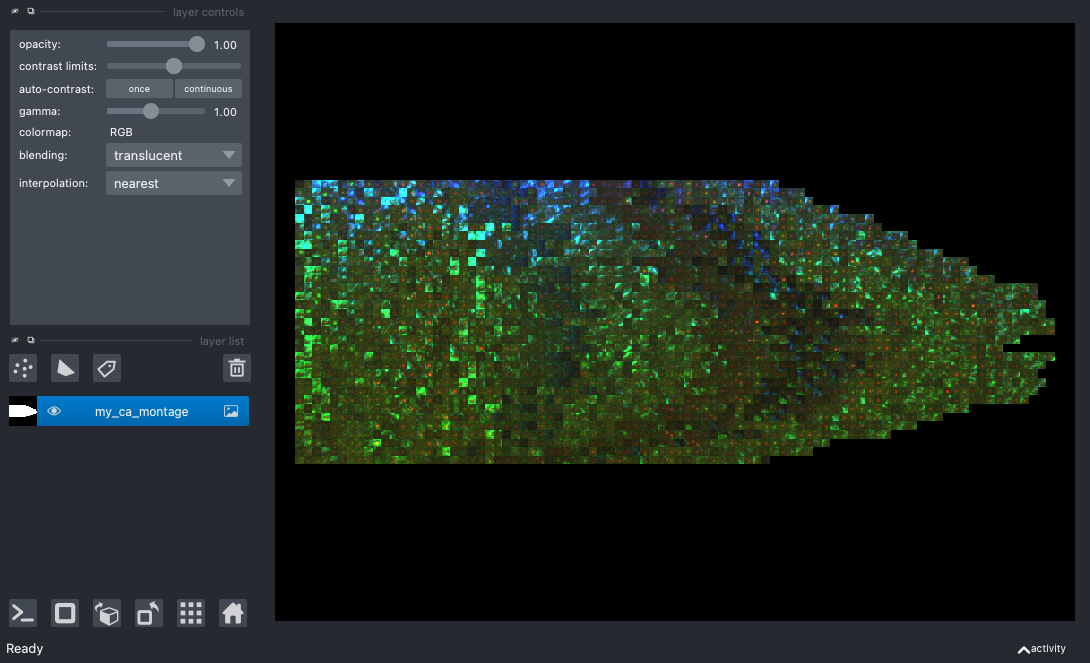

In [14]:
# view the action of montage [rows= time, columns = spot number]
viewer.add_image(my_ca_montage)
nbscreenshot(viewer)